# 1st Zermelo problem (with loss control / via augmentation)

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min - x_1(8), \\[0.5em]
        \dot{x}_1(t) = x_2(t) + \cos(u(t)), \; \text{for a.e. } t\in [0,8],\\[0.5em]
        \dot{x}_2(t) = \sin(u(t)),  \; \text{for a.e. } t\in [0,8], \\[0.5em]
        u(t) \in [-\frac{\pi}{2}, \frac{\pi}{2}], \; \text{for a.e. } t\in [0,8], \\[0.5em]
        x(0) = 0_{\mathbb{R}^2}, \quad x_2(8) = 4,\\[0.5em]
        \{x \mid 0.5 <x_2 < 3.5 \} \text{ is a loss control region.}
    \end{array}
    \right.
$$

In [1]:
using JuMP  
using Ipopt
using Plots
using Plots.PlotMeasures

In [12]:
mutable struct Direct
  t ; t1 ; t2 ; x1 ; y1 ; x2 ; y2 ; x3 ; y3 ; u1 ; u2 ; u3 ; p1; p2; p3; q1; q2; q3
end

In [22]:
function ZERMELO(x0; solution=[], nsteps=400, display=true)
    
    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-6)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-6)
    set_optimizer_attribute(sys,"max_iter",600)
    
    N  = nsteps                 # Grid size
    
    @variables(sys, begin
               x1[1:N+1]                
               y1[1:N+1]               
        -π/2 ≤ u1[1:N+1] ≤ π/2  # control   
            
               x2[1:N+1]                
               y2[1:N+1]               
        -π/2 ≤ u2[1:N+1] ≤ π/2  # state
            
               x3[1:N+1]                
               y3[1:N+1]                 
        -π/2 ≤ u3[1:N+1] ≤ π/2  # control
        
            
            0.0 ≤ t1  ≤ 8.0
            
            0.0 ≤ t2  ≤ 8.0


        end)
    
    Δt  =  1.0/(N+1) ; 
    
    # Objective
    @NLobjective(sys, Max, x3[N+1])
    
    # Boundary constraints
    @constraints(sys, begin
        con_x10, x1[1]      == x0[1]              
        con_y10, y1[1]      == x0[2]  
        con_y1f, y1[N+1]    == 0.5
            
        con_x20, x2[1]      == x1[N+1]  
        con_y20, y2[1]      == 0.5
        con_y2f, y2[N+1]    == 3.5

            
        con_x30, x3[1]      == x2[N+1]  
        con_y30, y3[1]      == 3.5 
        con_x3f, y3[N+1]    == 4.0 

        con_t,     t2 - t1 >= 0                       
        
        con_u20, - π/2  ≤ u2[1]   ≤ π/2        
        con_u2f, - π/2  ≤ u2[N+1] ≤ π/2   
            
        end)
    
    # Dynamics
    @NLexpression(sys, dx1[j = 1:N+1],t1*(y1[j] + cos(u1[j])))
    @NLexpression(sys, dy1[j = 1:N+1],t1*sin(u1[j]))  
    
    @NLexpression(sys, dx2[j = 1:N+1],(t2 - t1)*(y2[j] + cos(u2[j])))
    @NLexpression(sys, dy2[j = 1:N+1],(t2 - t1)*sin(u2[j]))    
    @NLexpression(sys, du2[j = 1:N+1], 0.0)    
    
    @NLexpression(sys, dx3[j = 1:N+1],(8.0 - t2)*(y3[j] + cos(u3[j])))
    @NLexpression(sys, dy3[j = 1:N+1],(8.0 - t2)*sin(u3[j])) 

    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dy1[j=1:N], y1[j+1] == y1[j] + 0.5 * Δt * (dy1[j+1] + dy1[j])
        
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dy2[j=1:N], y2[j+1] == y2[j] + 0.5 * Δt * (dy2[j+1] + dy2[j])
        con_du2[j=1:N], u2[j+1] == u2[j]
        
        con_dx3[j=1:N], x3[j+1] == x3[j] + 0.5 * Δt * (dx3[j+1] + dx3[j])
        con_dy3[j=1:N], y3[j+1] == y3[j] + 0.5 * Δt * (dy3[j+1] + dy3[j])

        con_y1[j=1:N+1],        y1[j] <= 0.5 
        con_y2[j=1:N+1], 0.5 <= y2[j] <= 3.5 
        con_y3[j=1:N+1], 3.5 <= y3[j] 

     
    end);
    
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end
        
    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end    
        
    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    y1 = value.(y1)[:]
    u1 = value.(u1)[:]
    
    x2 = value.(x2)[:]
    y2 = value.(y2)[:]
    u2 = value.(u2)[:]

    x3 = value.(x3)[:]
    y3 = value.(y3)[:]
    u3 = value.(u3)[:]
    
    t  = (0:N) * value.(Δt)
    t1 = value.(t1)
    t2 = value.(t2)
  
    
   px10 =   dual(con_x10)
   qy10 =   dual(con_y10) 
   qy1f = - dual(con_y1f) 
    
   px20 =   dual(con_x20)
   qy20 =   dual(con_y20) 
   qy2f = - dual(con_y2f) 
    
   px30 =   dual(con_x30)
   qy30 =   dual(con_y30) 
   qy3f = - dual(con_x3f)
    

   sign = 1
    
   px1 = [ dual(con_dx1[i]) for i in 1:N ]
   qy1 = [ dual(con_dy1[i]) for i in 1:N ]
    
   px2 = [ dual(con_dx2[i]) for i in 1:N ]
   qy2 = [ dual(con_dy2[i]) for i in 1:N ]
    
   px3 = [ dual(con_dx3[i]) for i in 1:N ]
   qy3 = [ dual(con_dy3[i]) for i in 1:N ]
    


   px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2.]; 
   qy1 = sign * [qy10; (qy1[1:N-1]+qy1[2:N])/2.; qy1f]; 
    
   px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2.]; 
   qy2 = sign * [qy20; (qy2[1:N-1]+qy2[2:N])/2.; qy2f];
    
   px3 = sign * [px30; (px3[1:N-1]+px3[2:N])/2.]; 
   qy3 = sign * [qy30; (qy3[1:N-1]+qy3[2:N])/2.; qy3f]; 

    
   p1 = - [px10; px1[1:N]]; 
   q1 = - [qy10; qy1[1:N-1]; qy1f]; 
    
   p2 = - [px20; px2[1:N]]; 
   q2 = - [qy20; qy2[1:N-1]; qy2f]; 
     
   p3 = - [px30; px3[1:N]]; 
   q3 = - [qy30; qy3[1:N-1]; qy3f]; 
  
    return Direct(t , t1 , t2 , x1 , y1 , x2 , y2 , x3 , y3 , u1 , u2 , u3, p1, p2, p3, q1, q2, q3)
        
end;

In [23]:
# Resolution
x0  = [0.0; 0.0]

direct_sol = ZERMELO(x0);

Solving...
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    16011
Number of nonzeros in inequality constraint Jacobian.:     1209
Number of nonzeros in Lagrangian Hessian.............:    23200

Total number of variables............................:     3611
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1205
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2809
Total number of inequality constraints...............:     1208
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:      401
        inequality constraints with only upper bounds:      804

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00

In [24]:
t  = direct_sol.t
t1 = direct_sol.t1
t2 = direct_sol.t2

tX1 = t .* t1
tX2 = t1*ones(length(t)) + t .* (t2-t1)
tX3 = t2*ones(length(t)) + t .* (8.0-t2);
t_all = vcat(tX1, tX2, tX3);

In [25]:
x1 = direct_sol.x1
x2 = direct_sol.x2
x3 = direct_sol.x3
x  = vcat(x1, x2, x3)

y1 = direct_sol.y1
y2 = direct_sol.y2
y3 = direct_sol.y3
y  = vcat(y1, y2, y3)

u1 = direct_sol.u1
u2 = direct_sol.u2
u3 = direct_sol.u3
u  = vcat(u1, u2, u3);

p1 = direct_sol.p1
p2 = direct_sol.p2
p3 = direct_sol.p3
p  = vcat(p1, p2, p3);

q1 = direct_sol.q1
q2 = direct_sol.q2
q3 = direct_sol.q3
q  = vcat(q1, q2, q3);


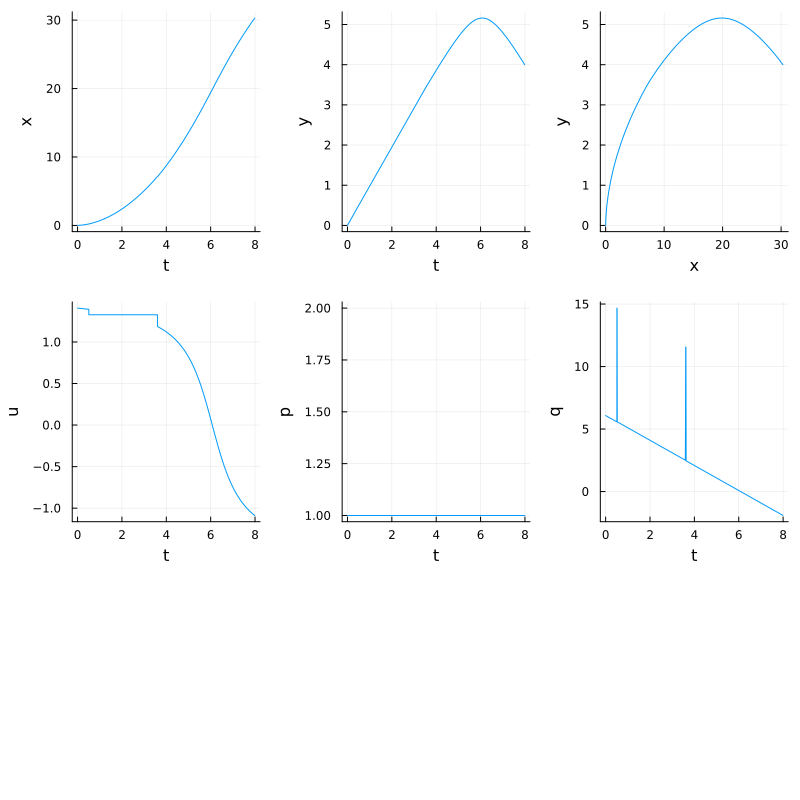

In [26]:
# Plots

x_plot   = plot(t_all, x,  xlabel = "t", ylabel = "x",  legend = false)
p_plot   = plot(t_all, p,  xlabel = "t", ylabel = "p",  legend = false)
q_plot   = plot(t_all, q,  xlabel = "t", ylabel = "q",  legend = false)


y_plot   = plot(t_all, y,  xlabel = "t", ylabel = "y",  legend = false)
u_plot    = plot(t_all, u,   xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) 
xy_plot = plot(x, y, xlabel = "x", ylabel = "y",  legend = false)

plot(x_plot, y_plot, xy_plot, u_plot, p_plot,q_plot, layout = (3,3), size=(800,800), left_margin=1mm)

# Indirect method 